### Intro & data

Photography and music have always been a way for me to capture emotions and moments in life. This is why I’ve been obsessed with curating playlists based on different themes. I believe in the power of music to reflect feelings, reminding me of specific memories—falling in love, striving for something meaningful, processing heartbreak, or simply reminiscing about the past.

For this project, my ultimate goal is to generate tags for my film photos and use those tags to find songs with lyrics that match their themes the best. However, for this assignment, I am focusing on classifying songs into four emotional categories based on their lyrics:

Romantic – Songs about love, devotion, and longing.
Breakup – Capturing the pain, loss, and emotional aftermath of separation.
Hopeful – Comforting or encouraging songs that help in difficult times.
Nostalgic – Songs that evoke memories of youth, growing up, or missing home.

Since Chinese lyrics often rely on metaphors and subtle expressions, I find them particularly beautiful and interesting to analyze. I chose these four themes because they represent the playlists I listen to the most, and they contain the largest number of songs in my collection.

To create a structured dataset of song lyrics, combines data from Spotify and Genius
I start with using Spotify’s API (via the Spotipy library) to extract detailed metadata from my playlists, including track names and artist information. 
With this metadata, I then use the Genius API (accessed through the LyricsGenius library) to search for and retrieve the corresponding lyrics for each song. 
The lyrics that can be found are saved as individual text files in a dedicated folder called 'lyrics'.

By leveraging these public APIs, we automate the extraction and aggregation of diverse musical content, making the dataset creation process efficient and scalable. 
Storing the lyrics locally allows us to apply standard data cleaning and exploratory analysis techniques using libraries like Jieba and pandas. 

In [ ]:
import os
import re
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import lyricsgenius

# -----------------------------
# Configure your API credentials
# -----------------------------
SPOTIPY_CLIENT_ID = 'b24b47adb2a94676bb924ab070b186f9'
SPOTIPY_CLIENT_SECRET = 'eb2285b6e27b4d4886b4f1c4ea008671'
SPOTIPY_REDIRECT_URI = 'http://localhost:8888/callback'
SCOPE = 'playlist-read-private'

GENIUS_ACCESS_TOKEN = '1OtAs6c9WU0RNaQHbO2evkUNLJfexp7n9Yjw1UkiMlM9Eier_lYN20odi0gQZfwu'

# -----------------------------
# Initialize the Spotify and Genius client
# -----------------------------
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=SPOTIPY_CLIENT_ID,
    client_secret=SPOTIPY_CLIENT_SECRET,
    redirect_uri=SPOTIPY_REDIRECT_URI,
    scope=SCOPE
))

genius = lyricsgenius.Genius(GENIUS_ACCESS_TOKEN, timeout=15, sleep_time=1)


def fetch_and_save_lyrics(sp, genius, playlist_id, save_folder):
    # Define the parent 'dataset' folder
    dataset_folder = "dataset"

    # Ensure the 'dataset' folder exists
    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    # Define the full path where lyrics should be saved
    full_save_folder = os.path.join(dataset_folder, save_folder)

    # Check if the lyrics folder exists in 'dataset'
    if not os.path.exists(full_save_folder):
        os.makedirs(full_save_folder)
        print(f"Created folder: {full_save_folder}")
    else:
        print(f"Folder already exists: {full_save_folder}")

    # Path to store previously searched songs
    searched_songs_file = os.path.join(full_save_folder, "searched_songs.txt")

    # Load previously searched songs into a set
    searched_songs = set()
    if os.path.exists(searched_songs_file):
        with open(searched_songs_file, "r", encoding="utf-8") as f:
            searched_songs = set(line.strip() for line in f)

    # Retrieve tracks from the playlist
    results = sp.playlist_items(playlist_id)
    tracks = results['items']

    # Fetch additional pages if available
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])

    # Create a list to store track metadata
    track_list = []

    print("Retrieving tracks from the Spotify playlist:")
    for item in tracks:
        track = item['track']
        track_name = track['name']
        artist_name = track['artists'][0]['name']  # Taking the first artist for simplicity
        track_list.append({'track_name': track_name, 'artist_name': artist_name})
        print(f" - {track_name} by {artist_name}")

    # Fetch and save lyrics for each track using Genius
    print("\nFetching and saving lyrics for each track:")
    for track in track_list:
        track_name = track['track_name']
        artist_name = track['artist_name']

        # Generate a unique key for tracking searches
        song_key = f"{artist_name} - {track_name}"

        # Skip if the song was already searched
        if song_key in searched_songs:
            print(f"Already searched '{track_name}' by {artist_name}. Skipping.")
            continue

        # Sanitize the filename by removing illegal characters
        safe_track_name = re.sub(r'[\\/*?:"<>|]', "", track_name)
        safe_artist_name = re.sub(r'[\\/*?:"<>|]', "", artist_name)
        filename = os.path.join(full_save_folder, f"{safe_artist_name}_{safe_track_name}.txt")

        try:
            # Search for the song on Genius
            song = genius.search_song(track_name, artist_name)

            # Log the search attempt
            with open(searched_songs_file, "a", encoding="utf-8") as f:
                f.write(song_key + "\n")

            if song:
                # Check if the lyrics contain at least one Chinese character
                if not re.search(r'[\u4e00-\u9fff]', song.lyrics):
                    print(f"'{track_name}' by {artist_name} does not appear to be in Chinese. Skipping.")
                    continue
                with open(filename, "w", encoding="utf-8") as f:
                    f.write(song.lyrics)
                print(f"Saved lyrics for '{track_name}' by {artist_name} to {filename}")
            else:
                print(f"Lyrics not found for '{track_name}' by {artist_name}.")
        except Exception as e:
            print(f"Error retrieving lyrics for '{track_name}' by {artist_name}: {e}")

In [ ]:
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:5xyY8qvuTT3bu7I4EZrrK8', "Hopeful")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:26wLPbk8pEGACMWLLQ6zAo', "Breakup")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:5NnmaHZisIOkTSQHrQySkN', "Breakup")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:4Vh7HQNrLVxLTTlHU2HD9G', "nostalgic")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:4wMV6VuktylzFKffYR0NCs', "nostalgic")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:1PVFBy9S4DaoKBwwDydlcg', "Romantic")

While building the dataset, I noticed that Genius did not have lyrics for many Chinese songs—particularly in the “breakup” and “nostalgia” categories. This shortage resulted in an unbalanced dataset, as these categories ended up underrepresented. To address this, I added more songs to increase the total number of samples and to ensure each category is more evenly represented. By expanding the dataset in this way, I aim to provide a more balanced and comprehensive collection of lyrics, which is crucial for training robust classification models.

In [ ]:
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:1N1fFRBzsWliaZper3WB9F', "Breakup")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:0D3ObU8Bq3FWy7aHjayLf9', "Nostalgic")

### Data Ingestion and Cleaning 

In [2]:
import os
import pandas as pd
import glob

def load_lyrics_data(root_folder="dataset"):
    """
    Loads song lyrics from text files stored in category-based subfolders.
    """
    data = []
    for category in os.listdir(root_folder):
        folder = os.path.join(root_folder, category)
        if os.path.isdir(folder):
            for filepath in glob.glob(os.path.join(folder, "*.txt")):
                with open(filepath, 'r', encoding='utf-8') as file:
                    lyrics = file.read().strip()
                data.append({
                    "filename": filepath,
                    "lyrics": lyrics,
                    "label": category
                })
    
    return pd.DataFrame(data)

df = load_lyrics_data()
print("Loaded data:")
print(df.head())

Loaded data:
                                   filename  \
0  dataset/Nostalgic/Hins Cheung_My Way.txt   
1      dataset/Nostalgic/Lolly Talk_三分甜.txt   
2             dataset/Nostalgic/易烊千璽_你說.txt   
3      dataset/Nostalgic/Eason Chan_任我行.txt   
4    dataset/Nostalgic/Eric Chou_小時候的我們.txt   

                                              lyrics      label  
0  3 ContributorsOn my way Lyrics[張敬軒「On my way」歌...  Nostalgic  
1  1 Contributor三分甜 (Triple Sweetness) Lyrics[Lol...  Nostalgic  
2  1 ContributorYou Say – Jackson’s solo (你说 – 易烊...  Nostalgic  
3  1 Contributor任我行 (The Wanderer) Lyrics[陳奕迅「任我行...  Nostalgic  
4  3 Contributors小時候的我們 (When We Were Young) Lyri...  Nostalgic  


Since I've been curating these playlists since 2019, it's possible that I've experienced different emotions for the same song over time, leading me to place it in multiple mood-based folders. To ensure that the categorization remains consistent and that no single song unduly influences any category, I decided to remove duplicate entries from the dataset. This process involved identifying songs with the same file name (indicating they are the same track) across all folders and removing all instances of duplicates. As a result, each song appears only once in the dataset, maintaining clear and distinct boundaries between categories.

In [3]:
# Check for duplicate file names across categories and remove all duplicates
df['basename'] = df['filename'].apply(lambda x: os.path.basename(x))
# Create a boolean mask where True indicates a duplicate (appearing more than once)
duplicates_mask = df['basename'].duplicated(keep=False)

if duplicates_mask.any():
    print("Duplicated file names found. Removing all instances of these duplicates:")
    print(df.loc[duplicates_mask, 'basename'].value_counts())
    # Keep only rows that are not duplicates
    df = df[~duplicates_mask]
else:
    print("No duplicated text file names found across categories.")

Duplicated file names found. Removing all instances of these duplicates:
basename
Dear Jane_到底發生過什麼事.txt     2
Joyce Cheng_我所看見的未來.txt    2
MIRROR_We All Are.txt      2
Cloud 雲浩影_無以名狀的痛.txt       2
Name: count, dtype: int64


In [4]:
print(df['label'].value_counts())

label
Romantic     65
Breakup      62
Hopeful      49
Nostalgic    46
Name: count, dtype: int64


After inspecting the dataset, it became clear that the four mood categories—“inlove,” “breakup,” “comforting,” and “nostalgia”—are not equally represented. For instance, “inlove” and “breakup” have more songs than “comforting” and “nostalgia.” This imbalance can skew the model, causing it to favor the overrepresented categories. Although I attempted to add more songs to the underrepresented categories, there is no guarantee that Genius can find lyrics for all of them, which further complicates the issue.

To handle this, I decided to construct a balanced dataset by using an undersampling approach. Specifically, I reduced each category to match the size of the smallest category. This ensures that each label has the same number of samples, preventing the model from overfitting to any single category and improving the overall reliability of the classification.

In [5]:
from sklearn.utils import resample

def balance_dataset(df, method="undersample"):
    """
    Balances the dataset so that all categories have the same number of samples.
    Options:
    - "undersample": Reduce larger categories to match the smallest one.
    - "oversample": Increase smaller categories to match the largest one.
    """
    if df.empty:
        print("Dataset is empty. Nothing to balance.")
        return df

    category_counts = df['label'].value_counts()
    min_samples = category_counts.min()
    max_samples = category_counts.max()

    if method == "undersample":
        # Reduce all categories to match the smallest one
        df_balanced = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=min(len(x), min_samples), random_state=42))
    elif method == "oversample":
        # Increase all categories to match the largest one
        df_balanced = df.groupby('label', group_keys=False).apply(lambda x: resample(x, replace=True, n_samples=max_samples, random_state=42))
    else:
        raise ValueError("Invalid balance method. Choose 'undersample' or 'oversample'.")

    return df_balanced.reset_index(drop=True)

df_balanced = balance_dataset(df, method="undersample") 
print("Balanced dataset:")
print(df_balanced['label'].value_counts())


Balanced dataset:
label
Breakup      46
Hopeful      46
Nostalgic    46
Romantic     46
Name: count, dtype: int64


/var/folders/hb/vs0ptz7977jgj7hy5m4jjjt80000gn/T/ipykernel_2368/443425185.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=min(len(x), min_samples), random_state=42))


The Jieba library is a Python tool designed specifically for Chinese text segmentation. 
It provides an efficient and accurate way to break continuous Chinese text into meaningful words for natural language processing (NLP) tasks. 
In projects involving Chinese language data like this, Jieba helps convert raw, unsegmented text into a tokenized format that is suitable for further analysis with machine learning.

One of Jieba's strengths is its ease of use and its ability to handle the unique challenges posed by the Chinese language, where words are not separated by spaces. 
It employs both dictionary-based methods and statistical algorithms to ensure accurate segmentation. 
Although it might not offer the extensive suite of tools available in libraries like NLTK for English text processing, 
Jieba is highly effective for Chinese text and integrates well into workflows that require quick and reliable tokenization for downstream NLP tasks.

The preprocess_lyrics_chinese function transforms raw Chinese song lyrics into a clean, standardized, and tokenized format ready for feature extraction. 
Each step in the process is designed to remove noise, ensure consistency, and prepare the text for effective downstream analysis.

1. Splitting and Header Removal:
When the lyrics is downloaded from genius, it contains a header that signifies the contributor and the title of the song.
To eliminate any extraneous information or metadata (such as titles or headers) that do not contribute to the core lyrical content, this step split the lyrics into individual lines to identigy and remove the header, ensuring that only the main body of the lyrics is processed.

2. Annotation Removal:
The downloaded lyrics also contains annotations (e.g., [Chorus]), and they are not part of the actual lyrical content. 
Removing them helps focus the analysis on the meaningful words and phrases within the song.

3. Rejoining and Punctuation Removal:
The filtered lines are rejoined into a single string, and both Chinese and English punctuation (e.g., commas, periods, exclamation points, parentheses) are removed. 
Since punctuation can interfere with tokenization and analysis by creating unnecessary splits or symbols, removing punctuation creates a smoother text flow for processing.

4. Conversion from Simplified to Traditional Chinese:
The cleaned text is converted from Simplified to Traditional Chinese using OpenCC.
This help standardizing the dataset to ensure that words with the same meaning but different character forms are treated uniformly, allowing accurate tokenization and frequency analysis.

5. Tokenization:
Tokenization is the process of splitting a string of text into individual words or tokens. 
This breaks down the lyrics into manageable units, which is crucial for subsequent steps like filtering and frequency analysis.
Chinese text does not naturally separate words with spaces, and the standardized text is tokenized using the jieba library.

6. Stopword Filtering:
Stopwords are common words that add little semantic value, and they can dilute the significance of the analysis. Tokens are filtered to remove common stopwords, so that the model can focus on the more informative words that are more indicative of the song's themes and content.

7. Filtering by Character Content:
Any token that does not contain at least one Chinese character is removed. This final filtering ensures that the analysis only includes relevant Chinese words, further reducing noise and improving the quality of the token set.

After these preprocessing, the tokens are rejoined into a space-separated string, which is a format well-suited for feature extraction, any subsequent machine learning or text analysis tasks.

In [52]:
import requests

# URL of the Chinese stopwords file (raw file from GitHub)
url = "https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt"

# Send a GET request to the URL
response = requests.get(url)

# Check if the download was successful
if response.status_code == 200:
    # Save the content to a file named "chinese_stopwords.txt"
    with open("chinese_stopwords.txt", "w", encoding="utf-8") as f:
        f.write(response.text)
    print("Downloaded Chinese stopwords successfully!")
else:
    print(f"Failed to download Chinese stopwords. Status code: {response.status_code}")

Downloaded Chinese stopwords successfully!


In [ ]:
import jieba
import opencc

# Convert from Simplified to Traditional Chinese
converter = opencc.OpenCC('s2t')

def load_chinese_stopwords(filepath):
    """
    Loads Chinese stopwords from a file.
    Assumes one stopword per line.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().split())
    return stopwords

# Load Chinese stopwords from your provided file.
chinese_stopwords = load_chinese_stopwords("chinese_stopwords.txt")

def preprocess_lyrics_chinese(text):
    """
    Preprocess Chinese lyrics by:
    1. Splitting text into lines and optionally discarding a header.
    2. Removing lines with annotations in square brackets (e.g., [Chorus]).
    3. Rejoining the text and removing common Chinese and English punctuation.
    4. Converting text from simplified to traditional Chinese.
    5. Tokenizing using jieba.
    6. Removing stopwords.
    7. Filtering out tokens that do not contain Chinese characters.
    Returns a space-separated string for feature extraction.
    """
    # 1. Split text into lines; remove header if needed
    lines = text.split('\n')
    if len(lines) > 0:
        lines = lines[1:]  # adjust if header is to be discarded

    # 2. Remove lines with annotations like [Chorus]
    filtered_lines = [line for line in lines if not re.search(r'\[.*?\]', line)]
    
    # 3. Rejoin into a single string
    cleaned_text = ' '.join(filtered_lines)
    
    # 4. Remove punctuation: expand to include parentheses and common English punctuation
    punctuation_pattern = r'[，。！？、；：“”‘’《》,!?.:;\'"()\[\]<>-]'
    cleaned_text = re.sub(punctuation_pattern, '', cleaned_text, flags=re.UNICODE)
    
    # 5. Convert simplified Chinese to traditional Chinese
    cleaned_text = converter.convert(cleaned_text)
    
    # 6. Tokenize using jieba
    tokens = jieba.lcut(cleaned_text)
    
    # 7. Remove stopwords
    tokens = [word for word in tokens if word not in chinese_stopwords]
    
    # 8. Filter tokens: keep only tokens that contain at least one Chinese character
    tokens = [word for word in tokens if re.search(r'[\u4e00-\u9fff]', word)]
    
    return " ".join(tokens)


# Apply preprocessing
df_balanced['processed'] = df_balanced['lyrics'].apply(preprocess_lyrics_chinese)
df_balanced['processed'] = df_balanced['processed'].fillna('').astype(str)
print("\nPreprocessed text sample:")
print(df_balanced[['label', 'processed']].head())

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/hb/vs0ptz7977jgj7hy5m4jjjt80000gn/T/jieba.cache
Loading model cost 0.445 seconds.
Prefix dict has been built successfully.



Preprocessed text sample:
     label                                          processed
0  Breakup  我來 城市 走過 來 時 路 想像 著 沒 日子 怎樣 孤獨 尋 得到 塵封 小店 回 不到...
1  Breakup  從 無 力量 狠 慘叫 賣力 照料 得到 敬愛像 親人 情人 其實 喜歡 紛擾 全因 太 對...
2  Breakup  還記 記得 最初 相信 還記 記得 孩子 般 簡單 愛情 我們 彷 彿 天生 一起 用不完 ...
3  Breakup  停 最遠處 送給 祝福 時常夢見 相識 一個 為 披起 婚紗慶祝 連幻覺 痛 卻 心足 聽 ...
4  Breakup  當 想念 慢慢 積攢 變成 一種 負擔 是不是 真的 該放 離開 沒 黑暗 地帶 努力 習慣...


### Exploratory Data Analysis:

We compute the number of tokens for each song to get an idea of text length and processing success.
Additionally, we visualize the distribution of token counts and compute the most common words across the dataset to understand the general vocabulary and dominant themes present in the lyrics, as well as confirm that the cleaning steps retain relevant content.


Descriptive Statistics:
count    184.000000
mean     312.994565
std       89.331427
min        0.000000
25%      262.000000
50%      308.000000
75%      368.500000
max      554.000000
Name: num_tokens, dtype: float64


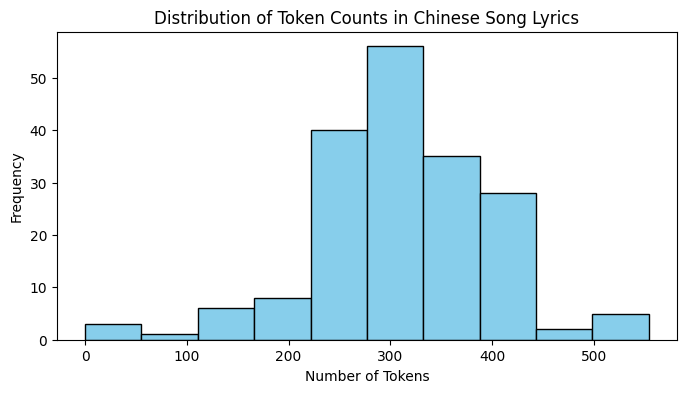


Most Common Words in the Chinese Lyrics Dataset:
說: 470
誰: 459
想: 380
我們: 355
會: 345
讓: 338
後: 305
於: 287
對: 285
愛: 281


In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# Calculate token counts per song (assuming tokens are separated by spaces)
# Convert non-string values or NaNs to an empty string


df_balanced['num_tokens'] = df_balanced['processed'].apply(lambda x: len(x.split()))
print("\nDescriptive Statistics:")
print(df_balanced['num_tokens'].describe())

# Plot token count distribution
plt.figure(figsize=(8, 4))
plt.hist(df_balanced['num_tokens'], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of Token Counts in Chinese Song Lyrics")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

# Find most common words across all songs
all_tokens = [token for processed in df_balanced['processed'] for token in processed.split()]
word_counts = Counter(all_tokens)
common_words = word_counts.most_common(10)
print("\nMost Common Words in the Chinese Lyrics Dataset:")
for word, count in common_words:
    print(f"{word}: {count}")

The histogram illustrates the distribution of token counts in the Chinese lyrics dataset, with most songs containing between 250 and 400 tokens. 
The distribution appears somewhat right-skewed, indicating a small number of songs with significantly fewer or more tokens than the average. 
This suggests that while most songs fall within a moderate length range, a few outliers have either very short or very long lyrics.

Understanding token count distributions is useful for preprocessing decisions, such as defining length thresholds for filtering or padding sequences in machine learning applications. 
If extreme outliers exist, we might consider normalizing the dataset by excluding excessively short or long songs to maintain consistency in model training.

The most common words in the lyrics dataset include:
說 (say), 誰 (who), 想 (think/want), 後 (after), 我們 (we/us), 著 (with/-ing), 對 (right/towards), 會 (will), 要 (need), 於 (at)
These words indicate common themes in Chinese lyrics:
-  "說" (say), "誰" (who), "想" (think) suggest a conversational or reflective nature, reinforcing that Chinese songs often explore inner emotions, questions, and relationships.
- "後" (after) and "於" (at) imply movement through time and space, possibly indicating themes of change, nostalgia, or longing.
-  "我們" (we) suggests frequent use of first-person plural pronouns, which may imply a strong emphasis on shared experiences, relationships, or group identity.
- "會" (will) and "要" (want) point to themes of aspiration, intention, and choice, which are common in both love songs and motivational lyrics.

Since Chinese does not use spaces to separate words, segmentation accuracy significantly impacts frequency counts. 
The observed frequent words may include some function words that are not typically considered stopwords in English NLP but could still be filtered in specific modeling tasks.

In terms of implications for NLP Processing
Some high-frequency words like "我們" (we) or "於" (at) may function as stopwords in certain contexts. 
While standard stopword lists exist for Chinese, we may need to customize our stopword list based on the dataset to filter out high-frequency but low-meaning words.

Unlike English, where tokenization is straightforward, Chinese NLP requires careful segmentation.
We should assess whether the current tokenization approach (e.g., Jieba, PKUSEG, Stanford NLP) effectively captures meaningful words or if modifications (custom dictionaries, domain-specific tuning) are necessary.

Since common words alone may not provide sufficient insight, bigrams, trigrams, or contextual embeddings (eg BERT) can help uncover thematic structures in the lyrics. This is particularly useful because a word like "後" could have different meanings depending on context (e.g., "後來" means later, while "最後" means final).

Many of these frequent words could be overrepresented in the chorus due to repetition. 
To avoid misleading frequency-based models, an analysis distinguishing verses from choruses could improve lyrical structure understanding and ensure fair weighting.

### Step 4: Analysis
- discussing the analysis (classification, regression, or clustering) that will be conducted on the data
- code performs any necessary data splits (such as creating training and test sets)

The objective of assignment 1 is to predict which category a song belongs to (comforting, nostalgia, breaking up, or love) based on its lyrics. 

This is a classification problem because the output is a discrete label chosen from a fixed set of categories. 

After balancing and preprocessing the dataset, the data is seperated into training set and test set. This allows for the evaluation of how well the model generalizes to new, unseen data.

The training set help the model to learn patterns and relationships in the lyrics that distinguish one category from another. 
Here, it contains 80% of samples from the entire dataset.

As for the test set, the key idea is that the model does not see these samples during training. 
After the model is trained, it is evaluated on the data in test set to gauge how well it can predict the correct category for songs it has never encountered before.
Here, the remaining 20% of the data is reserved for test set.

The training set is deliberately made larger, so that the model has enough examples to learn from.
At the same time, it is also important to have a sufficiently sized test set to provide a reliable estimate of how the model will perform on real-world data.

In [38]:
from sklearn.model_selection import train_test_split
import numpy as np

# Explanation:
# X contains the processed lyrics (text transformed to a space-separated string after segmentation).
# y contains the corresponding labels (categories such as comforting, growing up, breaking up, love).
# Extract features and labels.
X = df_balanced['processed']  # List of text documents
y = df_balanced['label']  # Class labels as a NumPy array

# We use train_test_split to create a training set and a test set.
# The test_size parameter is set to 0.2, meaning 20% of the data is reserved for testing.
# random_state is set for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the size of each split to confirm
print("Total samples:", len(df_balanced))
print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

Total samples: 184
Training samples: 147
Test samples: 37


**explain why this number is sufficient**

### Step 5: Model Selection

- discuss model** selection** in a markdown section 
- [code] model initialization and construction in a well-commented code block. 
- This section should include a clear discussion of the model's mathematical underpinnings -> include typeset equations and/or algorithms as pseudocode.


##### Naive Bayes

Naive Bayes is a simple yet powerful probabilistic classifier based on Bayes' Theorem. Bayes' Theorem is a way to update our beliefs based on new evidence. It tells us how likely a particular class is (for example, "breakup" or "inlove" for a song) given the observed words in the lyrics.

Bayes' Theorem:

$P(C_k \mid x) = \frac{P(x \mid C_k) \, P(C_k)}{P(x)}$   

where

- $P(C_k \mid x)$ refers to the probability that a song belongs to class $C_k $ (e.g., "breakup") given the lyrics $x$
- $P(x \mid C_k)$ refers to the likelihood of observing the lyrics  $x$ if we already knew the song was in class $C_k$
- $P(C_k)$ refers to the prior of how common class $C_k$ is (for example, in this case, the classes are balanced, 25% of our songs are breakup songs, then P(breakup)=0.25).
- $P(x)$ refers to the normalizing constant ensuring that the probabilities for all classes add up to 1.

Because we assume that the tokens are conditionally independent given the class, we can simplify the likelihood $P(x \mid C_k)$ as:

$P(x \mid C_k) \approx \prod_{i=1}^{n} P(x_i \mid C_k)$

where $x_i$ represents the i-th token in the lyrics. 

Since we want choose the class $C_k$ that maximizes posterior probability (i.e., the product of the prior probability and the likelihoods of all the tokens given that class), the final prediction:

$\hat{y} = \arg\max_{k} \, P(C_k) \prod_{i=1}^{n} P(x_i \mid C_k)$




The term "naive" here refers to the simplified ("naive") assumptions for the model, which is the assumption that all tokens (features) are conditionally independent given the class label. 
As words in a sentence influence each other, this assumption is an oversimplificiation.
However, Naive Bayes is generally still regard as a strong baseline for text classification because it provides a reasonable approximation that performs well in practice.

For this project, Multinomial Naive Bayes is chosen over Gaussian Naive Bayes due to the nature of the feature representation. 
Multinomial Naive Bayes assumes that features (i.e. TF–IDF scores) are generated from a multinomial distribution; whereas, Gaussian Naive Bayes assumes that features follow a normal distribution, which is more appropriate for continuous numerical data. 

While TF–IDF values are continuous, they tend to be sparse and skewed and do not follow a Gaussian distribution. So, Gaussian Naive Bayes would not be as effective in this case. 
Multinomial Naive Bayes, despite being originally designed for discrete count data, has been widely used for TF–IDF-based text classification.

Additionally, Naive Bayes is chosen over Multi-Layer Perceptron (MLP) for classification in this case. 
MLP, as a neural network-based classifier, requires significantly more training data to generalize well, whereas Naive Bayes performs well even with smaller datasets, which matches what we have for pipeline 1 (147 samples)
Also, Naive Bayes is much faster and computationally efficient, making it ideal for high-dimensional text data where features (words) are sparse. 
While MLP can achieve higher accuracy with sufficient data and fine-tuning, it is more prone to overfitting on small datasets, requires substantial training time, and lacks the interpretability of Naive Bayes, which provides clear probabilistic outputs. 


In [ ]:
# --------------------------
# Pseudocode for Naive Bayes Classification
# --------------------------
# Given a document x represented as TF-IDF features:
#
# For each class C_k in the set of possible classes:
#     Compute the prior probability P(C_k) from the training data.
#     For each feature x_i in the document x:
#         Compute the likelihood P(x_i | C_k).
#     Compute the posterior probability:
#         P(C_k | x) ∝ P(C_k) * Π (over i) P(x_i | C_k)
#
# Predict the class that maximizes the posterior probability:
#     y_pred = argmax_k P(C_k | x)
#
# This is essentially what the MultinomialNB implementation does under the hood.

# The nb_pipeline is now ready to be trained on the dataset.
# For example, if X_train contains the song lyrics and y_train contains the corresponding labels,
# you would train the model as follows:
# nb_pipeline.fit(X_train, y_train)

# After training, predictions can be made with:
# y_pred = nb_pipeline.predict(X_test)

In classification tasks, the input data is represented numerically, because most machine learning algorithms work with numerical vectors rather than raw text.
This allows models to detect patterns and associations between word usage and the song’s category, apply learned weights to new, unseen tokens, and use optimization like gradient descent on continuous numerical data.

To convert to numbers, For naive bayes we are using Term Frequency–Inverse Document Frequency (TF‑IDF).

TF‑IDF is used to quantify the importance of a token in a song relative to the entire dataset. 
It helps to weigh down common words while highlighting words that are more distinctive.
For a token $t$ in a document (i.e., a song's lyrics) $d$, TF‑IDF is computed as:

$TF-IDF(t,d)=TF(t,d)×IDF(t,D)$, 

where: 

Term Frequency $\text{TF}(t, d)$ measures how often a token appears in the lyrics of a song, normalized by the total length of the document. 
A higher TF indicates the term is more significant within that document.

$\text{TF}(t, d) = \frac{\text{count}(t, d)}{\sum_{t' \in d} \text{count}(t', d)} = \frac{\text{the number of times a token appears in the song}}{\text{the total number of tokens in the song}}$

Inverse Document Frequency measures how “unique” or “rare” a token is across the entire dataset. 
If a token appears in many songs, the ratio inside the logarithm is smaller, leading to a lower IDF value is lower. 
This reduces the weight of very common words.

$\text{IDF}(t, D) = \log \left( \frac{N}{\left|\{\,d' \in D : t \in d'\}\right|} \right) = \frac{\text{the total number of songs in the entire dataset}}{\text{ the number of songs in which the token appears.}}$


As such, TF emphasizes how important a term is in a particular document, while IDF downweights terms that appear frequently across many documents.

As a result, the text is transformed into a vector where each component represents the TF‑IDF value of a specific term. 
This fixed-length vector can be fed into traditional classifiers like Naive Bayes or MLP.

TF-IDF is chosen over simple word count (i.e., raw frequency) because firstly, raw frequency assigns a higher importance to terms that appear frequently in longer documents, even if those terms are not particularly meaningful.
TF-IDF normalizes term frequency by the total number of words in a document, ensuring that longer lyrics do not automatically have an inflated weight for common words.
Secondly, it also helps reduce the impact of common words. For example, in a lyrics dataset, frequently occurring words would dominate classification if simple word count were used.
TF-IDF reduces the weight of such commonly occurring words across many songs while emphasizing distinctive words that help differentiate song categories (e.g., "童年 (childhood)" for nostalgic).

In [28]:
# Import necessary modules from scikit-learn
from sklearn.pipeline import Pipeline                     # For chaining preprocessing and modeling steps
from sklearn.feature_extraction.text import TfidfVectorizer  # For converting text into TF-IDF feature vectors
from sklearn.naive_bayes import MultinomialNB              # For the Naive Bayes classifier
from sklearn.metrics import classification_report           # For model evaluation

# --------------------------
# Naive Bayes Pipeline Setup
# --------------------------
# This pipeline consists of two main steps:
# 1. 'tfidf': Converts raw text (song lyrics) into numerical TF-IDF features.
#    - max_features=5000 limits the feature space to the top 5000 terms, reducing noise and computational cost.
# 2. 'clf': Applies the Multinomial Naive Bayes classifier on the TF-IDF features.
#    - MultinomialNB is well-suited for text data and works by estimating the probability of each class
#      based on the frequency of features (words) in the training data.

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Step 1: Text to TF-IDF vector conversion.
    ('clf', MultinomialNB())                         # Step 2: Naive Bayes classification.
])

# Training models
nb_pipeline.fit(X_train, y_train)

# Naive Bayes predictions
y_pred = nb_pipeline.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Breakup       0.80      0.73      0.76        11
     Hopeful       0.55      0.67      0.60         9
   Nostalgic       0.50      0.11      0.18         9
    Romantic       0.50      0.88      0.64         8

    accuracy                           0.59        37
   macro avg       0.59      0.60      0.55        37
weighted avg       0.60      0.59      0.55        37



#### k-fold cross-validation and hyperparamter tuning

In the above code cell, the evaluation is based on a single train-test split, meaning the model is trained on one fixed training set (147 samples) and tested on one fixed test set (37 samples). 

The issue with this approach is that the model's performance heavily depends on how the data was split—a different split could yield different results. 
A single train-test split might accidentally favor the model (if the test set happens to be easier to classify) or fail to capture its weaknesses (if the split is not representative of the overall dataset). 
This can be especially problematic with smaller datasets like ours (184 songs total), where variance in performance due to different splits can be high.

To get a more reliable estimate of model performance, I now implement K-fold cross-validation.

K-fold Cross-validation is a technique used to estimate how well a model generalizes to unseen data by splitting the training data into multiple “folds” ($k$). 
Rather than training and evaluating the model on a single train/test split, cross-validation cycles through different partitions of the training set as mini-train/validation sets, then averages the performance across these partitions.

This provides a more reliable performance estimates, because a single train/test split might accidentally favor the model or fail to capture its weaknesses, especially with a small dataset (184 songs in this case). Cross-validation helps mitigate this variance by averaging results across multiple splits.
Also, when tuning hyperparameters, there is a risk of overfitting to a single validation set. By using multiple folds, we can reduce the likelihood of “over‐fitting” to peculiarities in a single split.

The value of $k$ is selected to be 5, meaning that each fold contains roughly $\frac{1}{5}$ of the training data.
With only 147 training samples, 5-fold CV ensures each fold is still large enough to provide stable estimates. A higher $k$ like 10-fold could be used, but it might start introducing higher variance in each fold’s estimate, and the training overhead would double.

Below are the hypermeter chosen for tuning:

TF-IDF Vectorizer:
- max_features: controls how many terms (words, tokens) to keep in the vocabulary. Too few features can miss important words, too many might include noise. Values like None, 5000, and 10000 let us see if restricting the vocabulary helps or hurts performance.
- ngram_range: Decides whether to consider single words only (1,1) or pairs of words (1,2). As mentioned in EDA, sometimes bigrams capture phrases like a word like "後" could have different meanings depending on context (e.g., "後來" means later, while "最後" means final) more effectively.
- sublinear_tf: When it is set to be "True", it uses $1+log(tf)$ instead of raw term frequency. This can help if raw frequency skews the importance of very common words.

Naive Bayes:
- $\alpha$: This is for Laplace smoothing. Values like 0.1, 1.0, and 5.0 control how much we smooth zero counts. 
A smaller $\alpha$ relies more on observed data; a larger $\alpha$ flattens probabilities more aggressively. 
Since Naive Bayes is relatively simple, $\alpha$ can still significantly affect performance.

In [29]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the grid of hyperparameters to search over.
param_grid = {
    'tfidf__max_features': [None, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__sublinear_tf': [False, True],
    'clf__alpha': [0.1, 1.0, 5.0]
}

# Use stratified 5-fold cross-validation to ensure class proportions are preserved in each fold.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with the macro F1-score (multiclass) as our scoring metric.
grid_search = GridSearchCV(nb_pipeline, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data.
grid_search.fit(X_train, y_train)

# Evaluate the best model on the test set.
best_model = grid_search.best_estimator_
y_pred_k = best_model.predict(X_test)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_k))

Classification Report on Test Set:
              precision    recall  f1-score   support

     Breakup       0.62      0.91      0.74        11
     Hopeful       0.64      0.78      0.70         9
   Nostalgic       1.00      0.33      0.50         9
    Romantic       0.71      0.62      0.67         8

    accuracy                           0.68        37
   macro avg       0.74      0.66      0.65        37
weighted avg       0.74      0.68      0.66        37



Precision measures how many of the songs predicted as belonging to a particular category are actually correct. 
For example, if the model predicts 10 songs as "Breakup" and 8 are correct, the precision is 80%. 
A high precision means that when the model labels a song as "Breakup," it is likely correct. 
However, precision alone does not tell us whether the model is missing many actual breakup songs.

$\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$

Recall captures how many of the actual songs in a category were successfully identified. 
For instance, if there are 10 actual "Hopeful" songs, and the model correctly classifies 7 as "Hopeful" but mislabels 3, the recall is 70%. 
A high recall means the model successfully identifies most of the true instances of a class, but it does not necessarily ensure that all predictions for that class are correct.

$\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}$

F1-Score is the harmonic mean of precision and recall, balancing both metrics. 
This is particularly useful in cases like this dataset, where some categories may have low support (fewer examples) and where prioritizing one metric over the other (e.g., high recall but low precision) could lead to misclassifications. 
A high F1-score means the model is performing well in both aspects, correctly identifying songs without excessive false predictions.

$\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

Support refers to the number of actual occurrences of each class in the dataset. 
For instance, if only 9 songs in the test set belong to the "Nostalgic" category, any misclassification will have a significant impact on the model’s performance for that category. 
Support is essential for interpreting precision and recall—if a category has very low support, its precision and recall scores might be unstable.

Macro avg treats all categories equally, even if some have very few examples.
Weighted avg gives more importance to classes with higher support (more examples in the dataset).
Since the entire dataset is balanced (after resampling), it makes sense that macro and weighted averages scores are fairly close.

After performing 5-fold cross-validation and hyperparameter tuning, the final classification report on the test set shows an accuracy of 0.68, with a macro-average F1-score of 0.65 and a weighted-average F1-score of 0.66. 
This performance is meaningful because, with four categories, a random classifier would achieve only 25% accuracy on average. The achieved accuracy of 68% and F1-score above 0.65 demonstrate that the model is making informed classifications rather than random guesses.

The Breakup category achieves a recall of 0.91, meaning that nearly all actual breakup songs in the test set were correctly identified. 
However, the precision for this class is lower at 0.62, indicating that some non-breakup songs were mistakenly classified as breakup songs. 

Similarly, the Hopeful category performs well, with precision (0.64) and recall (0.78) leading to an F1-score of 0.70, showing a strong ability to correctly classify hopeful songs while maintaining reasonable precision.

The Nostalgic category stands out with a perfect precision of 1.00, meaning that every song classified as nostalgic was indeed nostalgic. 
However, the recall is only 0.33, indicating that the model fails to identify many actual nostalgic songs, leading to a lower F1-score of 0.50.
 This suggests that the model is highly conservative when predicting nostalgic songs, only assigning the label when it is highly confident, but at the cost of missing many actual nostalgic instances. 
 
 In contrast, the Romantic category achieves a more balanced performance with precision (0.71) and recall (0.62), leading to an F1-score of 0.67.

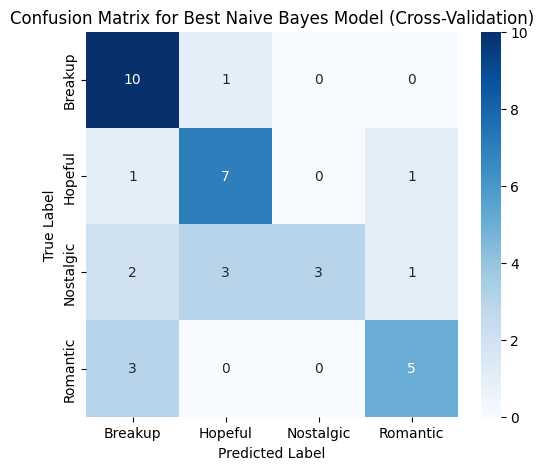

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_k)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix for Best Naive Bayes Model (Cross-Validation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

This confusion matrix represents the performance of the best Naive Bayes model on the test set, after performing 5-fold cross-validation and hyperparameter tuning.

The confusion matrix provides a deeper look at how misclassifications occur, complementing the classification report.

The Breakup category has 10 correct classifications, with only 1 false positive (misclassified as Hopeful) and no false negatives misclassified into other categories. 
This confirms that the model performs well in identifying breakup songs with high confidence.

For the Hopeful category, 7 of 9 songs were correctly classified, with 1 misclassified as Breakup and 1 misclassified as Romantic. 
The confusion between Hopeful and Breakup might stem from lyrical similarities where hope emerges as a theme following emotional distress.

The Nostalgic category struggles the most, with only 3 correct classifications out of 9. 
3 songs were misclassified as Hopeful, suggesting that some nostalgic lyrics may share characteristics with hopeful ones. 
Additionally, 2 were misclassified as Breakup, which may indicate that certain breakup-themed songs evoke nostalgia, leading to classification confusion.

For the Romantic category, 5 of 8 songs were correctly classified, but 3 were misclassified as Breakup, which could suggest an overlap between romantic and emotionally intense breakup songs.

In [31]:
# Print the best parameters and best cross-validation score.
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation macro F1-score:", grid_search.best_score_)

print("Classification Report (Single test split):")
print(classification_report(y_test, y_pred))


print("Classification Report (Cross Validation):")
print(classification_report(y_test, y_pred_k))

Best parameters found: {'clf__alpha': 0.1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': True}
Best cross-validation macro F1-score: 0.606786106050812
Classification Report (Single test split):
              precision    recall  f1-score   support

     Breakup       0.80      0.73      0.76        11
     Hopeful       0.55      0.67      0.60         9
   Nostalgic       0.50      0.11      0.18         9
    Romantic       0.50      0.88      0.64         8

    accuracy                           0.59        37
   macro avg       0.59      0.60      0.55        37
weighted avg       0.60      0.59      0.55        37

Classification Report (Cross Validation):
              precision    recall  f1-score   support

     Breakup       0.62      0.91      0.74        11
     Hopeful       0.64      0.78      0.70         9
   Nostalgic       1.00      0.33      0.50         9
    Romantic       0.71      0.62      0.67         8

    accuracy         

Comparing the single-test split model to the cross-validated model, we observe that accuracy increased from 0.59 to 0.68, and macro-average and weighted-average F1-scores both improved. 

A single-test split can sometimes be misleading because of potential overestimation or underestimation of performance due to random variations in data partitioning. 
The cross-validation approach provides a more stable estimate by averaging over multiple train-test divisions. 
This reinforces that the initial test-split model may have overfitted to a particular train/test division, whereas the cross-validation model generalizes better across different subsets of the dataset.

Additionally, hyperparameter tuning played a role to help optimize performance across different partitions of the data, leading to better overall classification.
The best-found parameters included $\alpha = 0.1$ for Laplace smoothing, which helps the model handle rare words better, and TF-IDF max features = 5000, ensuring that only the most relevant words are used in classification. 
The ngram range was set to (1,1), meaning unigrams (single words) were used instead of bigrams, likely because bigrams didn’t provide additional predictive value given the dataset's size. 
Sublinear TF scaling was enabled, meaning the term frequency transformation dampened the impact of extremely frequent words, making rare but meaningful terms more influential in classification.

#### Building from scratch

To further my understanding of the model's mechanism and code, I built the Naive Bayes text classifier from scratch.
This version manually computes class priors and conditional probabilities without relying on external scikit-learn’s built-in Naive Bayes libraries. 

The classifier is specifically designed to work with TF-IDF features instead of raw word counts, meaning that instead of treating term frequencies as direct feature counts, it scales features based on their informativeness across the dataset. 
This avoids giving too much weight to highly frequent but uninformative words and instead prioritizes words that uniquely characterize a given class. 
The way this is achieved in the model is through computing conditional probabilities not over raw counts of words, but over the sum of TF-IDF scores per class. 
As a result, the probability of a word in a class depends on its weighted presence rather than simple occurrence frequency.

During training (fit method), it begins by computing class prior probabilities $P(c)$, which represent how frequently each class appears in the dataset. 
Next, for each class, the TF-IDF values of all documents belonging to that class are summed to create a representation of feature importance per class. 
Laplace smoothing is applied to prevent zero probabilities for unseen words. 
This is necessary because, in probabilistic models, a zero probability for any feature (word) in a class would cause the entire class probability computation to be zero when using multiplication (or negative infinity when working with log probabilities). 
To prevent this, we add a small constant $\alpha = 1$ to every probability calculation. 
Choosing $\alpha = 1$ represents "add-one smoothing," which ensures that every feature has at least some probability mass, avoiding division by zero issues and preventing extreme biases in classification. 
While alternative values for $\alpha$ (e.g., 0.1 or 10) could be used to fine-tune the degree of smoothing, $\alpha = 1$ is a commonly used default that balances smoothing without overly distorting word importance.
The model then normalizes these smoothed values to obtain the conditional probability $P(feature∣c)$, which estimates the likelihood of each word given a class.

During prediction (predict method), the model evaluates each document by computing the log probability of belonging to each class. 
This is done by summing the log prior probability $logP(c)$ and the weighted sum of log conditional probabilities $\sum_{j} \text{TF-IDF}_j \cdot \log P(\text{word}_j \mid c)$. 
This formulation means that words with higher TF-IDF scores in a document contribute more significantly to the final probability of a class, emphasizing distinguishing terms rather than common stopwords. 
The class with the highest computed probability is chosen as the predicted label. 
This approach ensures that the model effectively balances prior knowledge of class distributions with the importance of words in each document.

One strength of implementing Naive Bayes from scratch is the flexibility it offers for customization. 
For example, in this implementation, the way conditional probabilities are computed has been modified to work specifically with TF-IDF rather than raw word counts. 
Additionally, the smoothing parameter $\alpha$ is explicitly set, allowing for experimentation with different values to observe their effects on classification. 

Another area of customization is in how probabilities are computed: instead of working in the traditional count-based space, we modify the denominator of the probability calculation to normalize by the total TF-IDF sum per class, ensuring the model properly accounts for the weighted nature of TF-IDF features. This level of control allows further optimizations, such as adjusting how much TF-IDF weight should influence probability calculations, or modifying how log probabilities are aggregated.

In [34]:
# Custom Naive Bayes classifier built from scratch
class CustomNaiveBayes:
    def __init__(self, alpha=1.0):
        """
        Initialize the classifier with a smoothing parameter.
        
        :param alpha: Laplace smoothing parameter to avoid zero probabilities.
        """
        self.alpha = alpha               # Laplace smoothing parameter
        self.class_priors = {}           # Dictionary to store prior probabilities for each class
        self.feature_prob = None         # Conditional probability matrix: shape (n_classes, n_features)
        self.classes = None              # Array of unique class labels

    def fit(self, X, y):
        """
        Train the Naive Bayes classifier using the provided TF-IDF feature matrix and labels.
        
        :param X: TF-IDF feature matrix (sparse matrix) where rows correspond to documents.
        :param y: Array-like of class labels for each document.
        """
        # Get the total number of documents and features
        n_docs, n_features = X.shape
        
        # Identify the unique classes and count how many there are
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Compute prior probabilities for each class: P(c) = (# documents in class c) / (total documents)
        self.class_priors = {c: np.sum(y == c) / float(n_docs) for c in self.classes}

        # Initialize an array to accumulate the sum of TF-IDF values per feature for each class.
        # This array has shape (n_classes, n_features)
        feature_sum = np.zeros((n_classes, n_features))
        
        # Loop over each class and sum the TF-IDF values for documents that belong to that class.
        for idx, c in enumerate(self.classes):
            # Get indices of documents that belong to class c
            indices = np.where(y == c)[0]
            # Sum the TF-IDF values along the document axis for class c
            # Convert the result to a flat array
            feature_sum[idx, :] = np.array(X[indices].sum(axis=0)).flatten()

        # Apply Laplace smoothing: add alpha to each "feature count" (here, weighted by TF-IDF)
        smoothed_fc = feature_sum + self.alpha
        
        # Compute the total sum of TF-IDF values per class after smoothing
        class_feature_sum = smoothed_fc.sum(axis=1)  # shape: (n_classes,)

        # Calculate the conditional probability for each feature given the class:
        # P(feature | class) = (smoothed TF-IDF count for feature) / (total smoothed TF-IDF count for class)
        self.feature_prob = smoothed_fc / class_feature_sum[:, np.newaxis]

    def predict(self, X):
        """
        Predict class labels for the given TF-IDF feature matrix.
        
        :param X: TF-IDF feature matrix (numpy array) for test documents.
        :return: Numpy array of predicted class labels.
        """
        predictions = []
        # Iterate over each document in the test set
        for i in range(X.shape[0]):
            # Directly use the row if X is a NumPy array
            # If it's sparse, you could use X[i].toarray().flatten()
            x_i = X[i, :].flatten()  
            log_probs = []
            
            # Compute the log probability for each class for this document.
            for idx, c in enumerate(self.classes):
                log_prob = np.log(self.class_priors[c])
                log_prob += np.sum(x_i * np.log(self.feature_prob[idx, :]))
                log_probs.append(log_prob)
            
            # The predicted class is the one with the highest computed log probability.
            predictions.append(self.classes[np.argmax(log_probs)])
        return np.array(predictions)



In [35]:
import math

class CustomTfidfVectorizer:
    def __init__(self,
                 max_features=None,
                 norm='l2',
                 sublinear_tf=False,
                 token_pattern=r'(?u)\b\w\w+\b'):
        """
        A custom TF-IDF vectorizer that approximates scikit-learn's defaults.

        :param max_features: Maximum number of terms to keep in the vocabulary.
        :param norm: The normalization to apply to each document vector ('l1', 'l2', or None).
        :param sublinear_tf: If True, replace term frequency tf with 1 + log(tf).
        :param token_pattern: Regex pattern to match tokens (similar to scikit-learn).
        """
        self.max_features = max_features
        self.norm = norm
        self.sublinear_tf = sublinear_tf
        self.token_pattern = re.compile(token_pattern)
        self.vocabulary_ = {}
        self.idf_ = {}

    def _tokenize(self, text):
        """
        Tokenize the input text using the specified regex pattern,
        converting to lowercase and matching words of length >= 2.
        """
        return self.token_pattern.findall(text.lower())

    def fit(self, documents):
        """
        Learn the vocabulary and idf from the training documents.

        :param documents: List of raw text documents.
        """
        n_docs = len(documents)
        term_doc_freq = {}

        # Build document frequency
        for doc in documents:
            tokens = set(self._tokenize(doc))
            for token in tokens:
                term_doc_freq[token] = term_doc_freq.get(token, 0) + 1

        # Sort terms by document frequency (descending)
        sorted_terms = sorted(term_doc_freq.items(), key=lambda x: x[1], reverse=True)

        # Limit vocabulary if max_features is specified
        if self.max_features:
            sorted_terms = sorted_terms[:self.max_features]

        # Build the vocabulary
        self.vocabulary_ = {term: idx for idx, (term, _) in enumerate(sorted_terms)}

        # Compute IDF with smoothing: idf = log((n_docs + 1) / (df + 1)) + 1
        for term, df in sorted_terms:
            self.idf_[term] = math.log((n_docs + 1) / (df + 1)) + 1

    def transform(self, documents):
        """
        Transform documents into a TF-IDF feature matrix.

        :param documents: List of raw text documents.
        :return: A numpy array of shape (n_documents, n_features) with TF-IDF values.
        """
        n_docs = len(documents)
        n_features = len(self.vocabulary_)
        X = np.zeros((n_docs, n_features), dtype=np.float64)

        for i, doc in enumerate(documents):
            tokens = self._tokenize(doc)
            term_counts = {}
            for token in tokens:
                if token in self.vocabulary_:
                    term_counts[token] = term_counts.get(token, 0) + 1

            total_terms = sum(term_counts.values())
            for term, count in term_counts.items():
                idx = self.vocabulary_[term]
                # Compute TF
                if self.sublinear_tf:
                    # Sublinear TF: tf = 1 + log(count)
                    tf = 1 + math.log(count) if count > 0 else 0
                    # If you do sublinear TF, you often don't normalize by total_terms
                    # but scikit-learn's default is to ignore total_terms in sublinear mode
                else:
                    # Standard TF
                    tf = count / total_terms if total_terms > 0 else 0

                # Multiply by IDF
                X[i, idx] = tf * self.idf_[term]

        # Apply L2 normalization if specified
        if self.norm == 'l2':
            row_norms = np.linalg.norm(X, axis=1)
            non_zero_rows = (row_norms != 0)
            X[non_zero_rows] = X[non_zero_rows] / row_norms[non_zero_rows][:, np.newaxis]

        return X

    def fit_transform(self, documents):
        """
        Fit to the data and transform it into a TF-IDF matrix in one step.

        :param documents: List of raw text documents.
        :return: TF-IDF feature matrix.
        """
        self.fit(documents)
        return self.transform(documents)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score

# Convert to NumPy arrays to avoid indexing errors
X_train = np.array(X_train)
y_train = np.array(y_train)

# Apply TF-IDF transformation ONCE (ensures consistency across folds)
vectorizer = CustomTfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit on full training set first

# Define number of folds
n_splits = 5  # 3 can be an alternative for smaller datasets
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store evaluation metrics across folds
f1_scores = []
accuracy_scores = []

# Loop through each fold
for train_idx, val_idx in cv.split(X_train_tfidf, y_train):
    # Split precomputed TF-IDF matrix
    X_train_fold, X_val_fold = X_train_tfidf[train_idx], X_train_tfidf[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Train custom Naive Bayes model
    custom_nb = CustomNaiveBayes(alpha=1.0)
    custom_nb.fit(X_train_fold, y_train_fold)

    # Predict on validation set
    y_pred_val = custom_nb.predict(X_val_fold)

    # Evaluate performance for this fold
    f1 = f1_score(y_val_fold, y_pred_val, average='macro')  # Macro F1-score
    acc = accuracy_score(y_val_fold, y_pred_val)  # Accuracy
    
    f1_scores.append(f1)
    accuracy_scores.append(acc)

# Compute mean cross-validation scores
mean_f1 = np.mean(f1_scores)
mean_accuracy = np.mean(accuracy_scores)

print(f"Cross-Validation Macro F1-score: {mean_f1:.4f}")
print(f"Cross-Validation Accuracy: {mean_accuracy:.4f}")

# --- Train Final Model on Full Training Set ---
X_test_tfidf = vectorizer.transform(X_test)  # Transform test set using the same vectorizer

# Train on full dataset
final_custom_nb = CustomNaiveBayes(alpha=1.0)
final_custom_nb.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_custom = final_custom_nb.predict(X_test_tfidf)

# Evaluate on test set
print("Classification Report (custom/built from scratch):")
print(classification_report(y_test, y_pred_custom))

# Comparison to verify whether the model is built correctly 
print("Classification Report (scikit-learn):")
print(classification_report(y_test, y_pred_k))


Cross-Validation Macro F1-score: 0.4532
Cross-Validation Accuracy: 0.4761
Classification Report (custom/built from scratch):
              precision    recall  f1-score   support

     Breakup       0.80      0.73      0.76        11
     Hopeful       0.60      0.67      0.63         9
   Nostalgic       0.67      0.22      0.33         9
    Romantic       0.50      0.88      0.64         8

    accuracy                           0.62        37
   macro avg       0.64      0.62      0.59        37
weighted avg       0.65      0.62      0.60        37

Classification Report (scikit-learn):
              precision    recall  f1-score   support

     Breakup       0.62      0.91      0.74        11
     Hopeful       0.64      0.78      0.70         9
   Nostalgic       1.00      0.33      0.50         9
    Romantic       0.71      0.62      0.67         8

    accuracy                           0.68        37
   macro avg       0.74      0.66      0.65        37
weighted avg       0.7

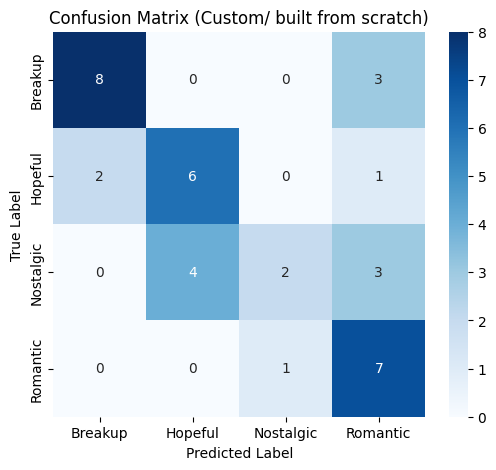

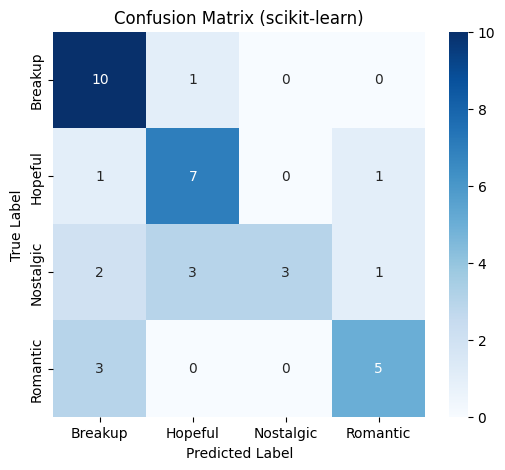

In [43]:
# Define class names
class_names = ['Breakup', 'Hopeful', 'Nostalgic','Romantic']  # Replace with your actual class labels

# Compute confusion matrix
cm_custom = confusion_matrix(y_test, y_pred_custom)

# Plot the heatmap with correct labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm_custom, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Custom/ built from scratch)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Generate the confusion matrix
cm_lib = confusion_matrix(y_test, y_pred_k)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lib, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix (scikit-learn)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The TF-IDF and Naive Bayes model built from scratch yields a result with similar patterns to that by built-in scikit-learn library, which verify that it is built correctly

From the classification reports, we can see that both the accuracy (0.62 vs. 0.68) and macro-average F1-scores (0.59 vs. 0.66) are comparable. 
This shows that the custom model is making reasonable predictions in line with the established model. 

Additionally, looking at the confusion matrices, both models exhibit the same general trends.
For example, there is a strong performance in classifying "Breakup" and "Hopeful" songs, while "Nostalgic" is the most misclassified category in both cases. 
These similarities confirm that the core logic of the implementation built by scratch aligns with the expected behavior of a Naive Bayes classifier.

The scikit-learn model performs slightly better in accuracy and F1-score. 
This discrepancy might be due to how scikit-learn is optimized to handle log probability calculations efficiently, reducing rounding errors that may accumulate in a custom implementation. 
Also, for the scikit-learn model, hyperparameter tuning was performed, whereas the custom model used a fixed α value (1.0) without further tuning.

If we look at the confusion matrices, the scikit-learn model correctly classifies more "Breakup" and "Nostalgic" songs. 
The custom model mistakenly assigns three "Breakup" songs as "Romantic", while scikit-learn classifies nearly all correctly.
Similarly, "Nostalgic" songs are more frequently misclassified by the custom model, often confused with "Hopeful" or "Romantic." 
These discrepancies suggest minor differences in TF-IDF probability incorporation and possible overfitting in the custom model, which lacks automated hyperparameter tuning.

#### Extension

As an extension of my analysis, I explored using BERT to enhance lyric classification.

BERT (Bidirectional Encoder Representations from Transformers) is a pretrained transformer-based language model developed by Google. 
Unlike traditional NLP models, which process text sequentially, BERT reads entire sequences bidirectionally, capturing contextual dependencies more effectively.
BERT is trained using masked language modeling (MLM) and next sentence prediction (NSP). 
MLM maskes random words in a sentence, so that the model predicts them using context; whereas, NSP helps BERT learn relationships between sentences by predicting whether two sentences are sequentially related.

Song lyrics, especially chinese songs, focuses a lot on metaphors, emotional expressions, and fragmented sentences
This require a deep understanding of semantic meaning, making BERT's feature of understanding contextual relationships between words useful. 
While Naïve Bayes models are computationally efficient and work well for simple text classification tasks, it doesnt have the capability to understand the ambiguous meanings and contextual dependencies found in song lyrics. 

For example, "紅了櫻桃 (The cherries turn red)" is a metaphor that signifies the passage of time and changes in life. 
However, the Naive Bayes would "红" (red) and "樱桃" (cherry) as independent words without recognizing the deeper meaning.
In constrast, BERT would be able to infer the metaphorical connection between the words. 

BERT is built on a Transformer Architecture, which consists of multiple layers of self-attention and feedforward networks.

It is called a  Transformer, because it transforms input (words) into useful representations that can be used for different tasks like classification.

Self-attention refers to mechanims that helps the model understand which words in a sentence are most relevant to each other. 
For BERT, it looks at the entire sentence at once and assigns different levels of importance to each word.

An example from one of the songs analyzed is that "還是月下老人他傻傻分不清 Or is it that Yue Lao (the Matchmaker God) foolishly can't tell the difference?" Self-attention in BERT allows "他" (he) to correctly refer to "月下老人" (the Matchmaker God) instead of just "老人" (old man) by analyzing the entire sentence context and assigning higher attention weights to "月下老人" as a single meaningful entity rather than treating "老人" independently.

$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

where:

Q (Query): What we are looking for (e.g., ""他 (he)").
K (Key): What is available in the sentence (e.g., "月下老人 (the Matchmaker God)" and "老人 (old man)").
V (Value): The actual meaning the model should focus on.

The softmax normalizes the scores to determine how much focus should be placed on each token.

Moreover, instead of computing a single self-attention score, BERT uses multiple self-attention heads to capture different relationships between words. 
Each attention head applies its own set of Q, K, V matrices, and their outputs are concatenated and projected into a single representation.
This helps the model understand different aspects of meaning

After self-attention figures out word relationships, the information goes through a feedforward network, which is a simple type of neural network that helps refine the understanding of the sentence.
This helps refine the learned representations before they move to the next layer in the Transformer.

Transformers don’t know word order on their own because they process all words at the same time.

To fix this, BERT uses positional encoding to add information about the order of words.
This is done using sine and cosine functions

$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d})$

$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d})$

where $pos$ is the position of the word and $d$ is the dimension of the word representation.

This ensures that the model knows if "我愛你 I love you" and "你愛我 You love I" are different sentences.

BERT is fine-tuned for specific tasks using a cross-entropy loss function

$L = -\sum_{i} y_i \log(\hat{y}_i)$

where $y_i$ is the true label and $\hat{y}_i$ is the predicted probability from BERT’s final classification layer.

This loss function helps the model adjust its predictions based on labeled data, ensuring better performance on classification tasks like lyric sentiment analysis.

Since all my lyrics are Chinese, I am using BERT-Chinese, a variant of BERT specifically trained on Chinese.

Unlike English, Chinese does not have explicit spaces between words. 
Thus, BERT-Chinese uses character-level tokenization, meaning each Chinese character is treated as a separate token. 

BERT-Chinese has been trained on large dataset of Chinese texts, allowing it to understand Chinese grammar, syntax, and common idioms more effectively.

Above, I have preprocessed the lyrics (eg tokenization, stopword removal, and text simplification) before putting it into the naive bayes model.

Nevertheless, BERT is designed to process raw text and learns contextual meaning directly from subword embeddings. 

BERT has its own built-in tokenizer that breaks words into subword units based on its pre-trained vocabulary, ensuring words are segmented into meaningful subwords while maintaining contextual dependencies.

Additionally, instead of relying on frequency-based features (TF-IDF for Naive Bayes above), BERT uses word embeddings that capture semantic relationships, allowing it to understand lyrics more effectively than a bag-of-words approach.


In [44]:
# Convert Simplified to Traditional Chinese
converter = opencc.OpenCC('s2t')

def preprocess_for_bert(text):
    """
    Preprocess lyrics for BERT:
    1. Remove annotations in square brackets (e.g., [Chorus]).
    2. Convert Simplified to Traditional Chinese.
    3. Keep text structure intact for BERT tokenization.
    """
    # Remove lines with annotations like [Chorus]
    text = re.sub(r'\[.*?\]', '', text)

    # Convert Simplified to Traditional Chinese
    text = converter.convert(text)

    return text.strip()

# Apply preprocessing
df_balanced['bert_input'] = df_balanced['lyrics'].apply(preprocess_for_bert)
df_balanced['bert_input'] = df_balanced['bert_input'].fillna('').astype(str)

In the code below, the lyrics first are tokenized using BERT’s built-in tokenizer, and the labels are converted into numbers so the model can understand them. 

The dataset is then split into training and test sets.

A LyricsDataset class is created to handle the lyrics and their labels, and a DataLoader is used to feed the data into the model in batches.

A pretrained BERT model is loaded and fine-tuned using the AdamW optimizer and cross-entropy loss for three epochs.

Gradient clipping (i.e., limiting the maximum value of gradient updates to prevent gradients from being too high) is used to keep the training stable.
There is also a learning rate scheduler that automatically reducing the learning rate when validation loss stops improving to help the model converge better.

After each epoch, the model's accuracy and loss are checked using a separate validation dataset.

In [53]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

# Ensure reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

# Encode labels
label_encoder = LabelEncoder()
df_balanced["encoded_label"] = label_encoder.fit_transform(df_balanced["label"])

# Create custom dataset class
class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Use `bert_input` instead of manually tokenized text
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_balanced["bert_input"].tolist(), df_balanced["encoded_label"].tolist(), test_size=0.2, random_state=42
)

# Create datasets and dataloaders
train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
test_dataset = LyricsDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load pretrained BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=len(label_encoder.classes_))
model.to(device)

# Define optimizer, loss function, and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = torch.nn.CrossEntropyLoss()

# Learning rate scheduler to reduce LR if loss plateaus
lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# Training loop with validation
num_epochs = 3
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()

        # Compute training accuracy
        preds = torch.argmax(outputs.logits, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)

    # Adjust learning rate if needed
    lr_scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

print("Training Complete!")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/hilarytang/opt/anaconda3/envs/156/lib/python3.9/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/Users/hilarytang/opt/anaconda3/envs/156/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/3 | Train Loss: 1.4003 | Train Acc: 0.2721 | Val Loss: 1.3271 | Val Acc: 0.2973
Epoch 2/3 | Train Loss: 1.1703 | Train Acc: 0.4966 | Val Loss: 1.3390 | Val Acc: 0.2973
Epoch 3/3 | Train Loss: 1.0060 | Train Acc: 0.5578 | Val Loss: 1.2433 | Val Acc: 0.4865
Training Complete!


In [ ]:
# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        
        y_true.extend(labels.cpu().tolist())  
        y_pred.extend(predictions.cpu().tolist())


# Decode labels
y_true_labels = label_encoder.inverse_transform(y_true)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluate model
print("BERT Classification Report:\n", classification_report(y_true_labels, y_pred_labels))
print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))

BERT Classification Report:
               precision    recall  f1-score   support

     Breakup       0.50      0.09      0.15        11
     Hopeful       0.73      0.89      0.80         9
   Nostalgic       1.00      0.33      0.50         9
    Romantic       0.29      0.75      0.41         8

    accuracy                           0.49        37
   macro avg       0.63      0.52      0.47        37
weighted avg       0.63      0.49      0.45        37

Accuracy: 0.4864864864864865


From the classification reports, it indicates that the Naïve Bayes model significantly outperforms BERT.

The BERT model achieves an accuracy of 49% and a macro F1-score of 0.47.
This is significantly lower than the Naïve Bayes models, which achieved 62% and 68% accuracy and macro F1-scores of 0.59 and 0.65 for custom and built-in respectively.

The recall scores for Naïve Bayes are higher across all categories, meaning it captures more instances correctly, especially for the Breakup and Hopeful classes.

There are a few reasons why BERT would underperform in this case.

Firstly, BERT requires extensive fine-tuning, but in this case, it was only trained for 3 epochs, which is not enough for the model to generalize well.
Secondly, BERT requires large amounts of labeled text to generalize well.
However, the dataset here is only 184 songs in total, which is too small for BERT to effectively learn patterns.
In contrast, Naïve Bayes relies on word frequency and does not need extensive training, making it more suitable for small datasets.

With such a small dataset and few epochs, BERT likely overfitted to specific examples without generalizing well.
Naïve Bayes, being a simple probabilistic model, generalizes better on small datasets as it relies on word likelihoods rather than complex contextual relationships.

Therefore, moving forward in assignment 2, I would increase the dataset size by collecting more labeled song lyrics and train for more epochs (around 10) to take advantage of the power of BERT. 

### Step 9: executive summary (of the prior eight sections)
- clearly explaining your steps
- diagramming your pipeline
- visualizing any key results
- explaining any key insights or shortcomings of your approach. 
- You may wish to include a discussion of how the model might be improved.


- increase size of data size --> more confident in the accuracy

### Step 10: references 
- documents, guides, or code repos you accessed for the project.